In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import chardet
import re
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Carga de datos
Centramos el analisis en los siguientes datasets, desde el año 2000 hasta la actualidad:

## Datasets con rallies

In [60]:
df_main = pd.read_csv('data_output/charting_clean.csv', low_memory=False) #Dataset principal, con rallies con todos los golpes juntos

df_main.head()

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2nd_test,rallyCountVerification,Player_svr,Player_ret,1st_player_svr,1st_player_ret,2nd_player_svr,2nd_player_ret,1st_final,2nd_final
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,1,Novak Djokovic,Ben Shelton,6,f2n#,NaN,NaN,6 f2n#,NaN
1,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0,1 (2),1,0,...,6 b19 f1 b2 s1 f3 f2 j2 *,8,Novak Djokovic,Ben Shelton,4n,NaN,6 f1 s1 f2,b19 b2 f3 j2*,4n,6 b19 f1 b2 s1 f3 f2 j2*
2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,3,0,0,0.0,0.0,15-15,1 (3),1,0,...,4 b28 f2 o1 *,4,Novak Djokovic,Ben Shelton,4d,NaN,4 f2,b28 o1*,4d,4 b28 f2 o1*
3,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,4,0,0,0.0,0.0,15-30,1 (4),1,0,...,NaN,3,Novak Djokovic,Ben Shelton,6 f3*,s28,NaN,NaN,6 s28 f3*,NaN
4,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,5,0,0,0.0,0.0,30-30,1 (5),1,0,...,NaN,3,Novak Djokovic,Ben Shelton,4 b3*,b37,NaN,NaN,4 b37 b3*,NaN


In [61]:
print(f'Filas y columnas: {df_main.shape}')

Filas y columnas: (741257, 41)


In [62]:
df_per_player = pd.read_csv('data_output/df_exploded_full.csv', low_memory=False) #Dataset con rallies separados por golpe

df_per_player.head()

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts
0,Novak Djokovic,6,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0
1,Ben Shelton,f2n#,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0
2,Novak Djokovic,4n,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
3,Novak Djokovic,6 f1 s1 f2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
4,Ben Shelton,b19 b2 f3 j2*,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0


In [63]:
print(f'Filas y columnas: {df_per_player.shape}')

Filas y columnas: (1679050, 9)


In [64]:
df_full_sequence = pd.read_csv('data_output/full_sequence.csv', low_memory=False) #Dataset con rallies completos (evita doble faltas)

df_full_sequence = df_full_sequence.drop(columns=['2nd_final'])
df_full_sequence = df_full_sequence.rename(columns={'1st_final': 'rally_sequence'})

df_full_sequence.head()

,1stIn,2ndIn,rally_sequence,Pt,Set1,Set2,Gm1,Gm2,TbSet,TB?,...,Ret,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,1,NaN,6 f2n#,1,0,0,0.0,0.0,1,0,...,2,False,False,False,True,False,False,1,1,1
1,0,1.0,6 b19 f1 b2 s1 f3 f2 j2*,2,0,0,0.0,0.0,1,0,...,2,False,False,True,False,False,False,2,0,8
2,0,1.0,4 b28 f2 o1*,3,0,0,0.0,0.0,1,0,...,2,False,False,True,False,False,False,2,0,4
3,1,NaN,6 s28 f3*,4,0,0,0.0,0.0,1,0,...,2,False,False,True,False,False,False,1,1,3
4,1,NaN,4 b37 b3*,5,0,0,0.0,0.0,1,0,...,2,False,False,True,False,False,False,1,1,3


In [65]:
print(f'Filas y columnas: {df_full_sequence.shape}')

Filas y columnas: (713303, 22)


## Datasets oficiales de Grand Slam

In [66]:
import os
import glob

path = 'tennis_slam_pointbypoint-master'
all_files = glob.glob(os.path.join(path, "*points.csv"))

#concat all files in one dataframe
df_from_each_file = (pd.read_csv(f, low_memory=False) for f in all_files)
df_points_grand_slam = pd.concat(df_from_each_file, ignore_index=True)

df_points_grand_slam.head()

,match_id,ElapsedTime,SetNo,P1GamesWon,P2GamesWon,SetWinner,GameNo,GameWinner,PointNumber,PointWinner,...,ServingTo,ServeNumber,WinnerType,WinnerShotType,P1DistanceRun,P2DistanceRun,RallyCount,ServeWidth,ServeDepth,ReturnDepth
0,2011-ausopen-1101,00:00:00,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-ausopen-1101,0:00:00,1.0,0.0,0.0,0.0,1.0,0.0,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-ausopen-1101,0:00:23,1.0,0.0,0.0,0.0,1.0,0.0,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-ausopen-1101,0:00:59,1.0,0.0,0.0,0.0,1.0,0.0,3,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-ausopen-1101,0:01:57,1.0,1.0,0.0,0.0,1.0,1.0,4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
print(f'Filas y columnas: {df_points_grand_slam.shape}')

Filas y columnas: (1828692, 65)


In [68]:
path = 'tennis_slam_pointbypoint-master'
all_files = glob.glob(os.path.join(path, "*matches.csv"))

#concat all files in one dataframe
df_from_each_file = (pd.read_csv(f, low_memory=False) for f in all_files)
df_matches_grand_slam = pd.concat(df_from_each_file, ignore_index=True)

df_matches_grand_slam.head()

,match_id,year,slam,match_num,player1,player2,status,winner,event_name,round,court_name,court_id,player1id,player2id,nation1,nation2
0,2011-ausopen-1101,2011,ausopen,1101,Rafael Nadal,Marcos Daniel,Retired,1.0,Men's Singles,Round 1,Rod Laver Arena,A,atpn409,atpd339,ESP,BRA
1,2011-ausopen-1103,2011,ausopen,1103,Bernard Tomic,Jeremy Chardy,Complete,1.0,Men's Singles,Round 1,Hisense Arena,B,atpta46,atpca12,AUS,FRA
2,2011-ausopen-1105,2011,ausopen,1105,John Isner,Florent Serra,Complete,1.0,Men's Singles,Round 1,Court 6,H,atpi186,atps963,USA,FRA
3,2011-ausopen-1108,2011,ausopen,1108,Donald Young,Marin Cilic,Complete,2.0,Men's Singles,Round 1,Show Court 2,D,atpy124,atpc977,USA,CRO
4,2011-ausopen-1112,2011,ausopen,1112,Juan Ignacio Chela,Michael Llodra,Complete,2.0,Men's Singles,Round 1,Show Court 2,D,atpc514,atpl428,ARG,FRA


In [69]:
print(f'Filas y columnas: {df_matches_grand_slam.shape}')

Filas y columnas: (10008, 16)


## Datasets oficiales de ATP

In [70]:
# from folder tennis_atp-master, read all the files with the formar atp_matches_ from the 2000 to 2022 
path = 'tennis_atp-master'
#filtro a partidos desde el 2000
all_files = glob.glob(os.path.join(path, "atp_matches_2*.csv"))

#concat
df_from_each_file = (pd.read_csv(f, low_memory=False) for f in all_files)
df_atp = pd.concat(df_from_each_file, ignore_index=True)

df_atp.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-301,Auckland,Hard,32,A,20000110,1,103163,1.0,NaN,...,55.0,39.0,29.0,17.0,4.0,7.0,11.0,1612.0,63.0,595.0
1,2000-301,Auckland,Hard,32,A,20000110,2,102607,NaN,Q,...,32.0,25.0,18.0,12.0,3.0,6.0,211.0,157.0,49.0,723.0
2,2000-301,Auckland,Hard,32,A,20000110,3,103252,NaN,NaN,...,33.0,20.0,7.0,8.0,7.0,11.0,48.0,726.0,59.0,649.0
3,2000-301,Auckland,Hard,32,A,20000110,4,103507,7.0,NaN,...,43.0,29.0,14.0,10.0,6.0,8.0,45.0,768.0,61.0,616.0
4,2000-301,Auckland,Hard,32,A,20000110,5,102103,NaN,Q,...,46.0,34.0,18.0,12.0,5.0,9.0,167.0,219.0,34.0,873.0


In [71]:
print(f'Filas y columnas: {df_atp.shape}')

Filas y columnas: (73247, 49)


## Datasets de jugadores

In [72]:
df_players = pd.read_csv('tennis_atp-master/atp_players.csv')

df_players.head()

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
1,100002,Pancho,Segura,R,19210620.0,ECU,168.0,Q54581
2,100003,Frank,Sedgman,R,19271002.0,AUS,180.0,Q962049
3,100004,Giuseppe,Merlo,R,19271011.0,ITA,NaN,Q1258752
4,100005,Richard,Gonzalez,R,19280509.0,USA,188.0,Q53554


In [73]:
print(f'Filas y columnas: {df_players.shape}')

Filas y columnas: (65019, 8)


In [74]:
grand_slams = ['Australian Open', 'Roland Garros', 'Wimbledon', 'US Open']

# obtener una lista con todos los nombres unicos, de entre las columnas winner_name y loser_name
players = pd.concat([df_atp['winner_name'], df_atp['loser_name']]).replace(' ', '', regex=True)

#lower players names
players = players.str.lower().unique()

In [75]:
"""df_players['nombre_completo'] = df_players['name_first'] + df_players['name_last']
df_players['nombre_completo'] = df_players['nombre_completo'].str.lower()
filtro_df_players = df_players[df_players['nombre_completo'].isin(players)]

df_matches_grand_slam['player1_filtro'] = df_matches_grand_slam['player1'].replace(' ', '', regex=True).str.lower()
df_matches_grand_slam['player2_filtro'] = df_matches_grand_slam['player2'].replace(' ', '', regex=True).str.lower()

df_matches_grand_slam_filtro = df_matches_grand_slam[(df_matches_grand_slam['player1_filtro'].isin(filtro_df_players['nombre_completo'])) | (df_matches_grand_slam['player2_filtro'].isin(filtro_df_players['nombre_completo']))]"""

"df_players['nombre_completo'] = df_players['name_first'] + df_players['name_last']\ndf_players['nombre_completo'] = df_players['nombre_completo'].str.lower()\nfiltro_df_players = df_players[df_players['nombre_completo'].isin(players)]\n\ndf_matches_grand_slam['player1_filtro'] = df_matches_grand_slam['player1'].replace(' ', '', regex=True).str.lower()\ndf_matches_grand_slam['player2_filtro'] = df_matches_grand_slam['player2'].replace(' ', '', regex=True).str.lower()\n\ndf_matches_grand_slam_filtro = df_matches_grand_slam[(df_matches_grand_slam['player1_filtro'].isin(filtro_df_players['nombre_completo'])) | (df_matches_grand_slam['player2_filtro'].isin(filtro_df_players['nombre_completo']))]"

Los datos son muchos y de diversas fuentes, por lo que se procede filtrar por jugadores, de manera que se pueda hacer un análisis particular.

In [76]:
# Crea columna combinando los nombres 'name_first' y 'name_last'
df_players['nombre_completo'] = df_players['name_first'] + df_players['name_last']
df_players['nombre_completo'] = df_players['nombre_completo'].str.lower() # Convierte a minúsculas

# Filtra 'df_players' para quedarse solo con los jugadores cuyos nombres completos están en la lista 'players'
filtro_df_players = df_players[df_players['nombre_completo'].isin(players)]

# Elimina espacios y convierte a minúsculas la columna 'player1'
df_matches_grand_slam['player1_filtro'] = df_matches_grand_slam['player1'].replace(' ', '', regex=True).str.lower()
df_matches_grand_slam['player2_filtro'] = df_matches_grand_slam['player2'].replace(' ', '', regex=True).str.lower() # Aplica el mismo proceso para la columna 'player2'

# Filtra los partidos en 'df_matches_grand_slam' donde al menos uno de los jugadores (player1 o player2)
# está en la lista de jugadores filtrados ('filtro_df_players')
df_matches_grand_slam_filtro = df_matches_grand_slam[
    (df_matches_grand_slam['player1_filtro'].isin(filtro_df_players['nombre_completo'])) | 
    (df_matches_grand_slam['player2_filtro'].isin(filtro_df_players['nombre_completo']))
]


Situacion similar con los partidos de grand slam, se consideran solo los partidos con informacion del mismo en otra tabla.

In [77]:
df_points_grand_slam = df_points_grand_slam[df_points_grand_slam['match_id'].isin(df_matches_grand_slam_filtro['match_id'])] # Filtra 'df_points_grand_slam' para quedarse solo con los partidos que están en 'df_matches_grand_slam_filtro'
df_points_grand_slam.head(3)

,match_id,ElapsedTime,SetNo,P1GamesWon,P2GamesWon,SetWinner,GameNo,GameWinner,PointNumber,PointWinner,...,ServingTo,ServeNumber,WinnerType,WinnerShotType,P1DistanceRun,P2DistanceRun,RallyCount,ServeWidth,ServeDepth,ReturnDepth
0,2011-ausopen-1101,00:00:00,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-ausopen-1101,0:00:00,1.0,0.0,0.0,0.0,1.0,0.0,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-ausopen-1101,0:00:23,1.0,0.0,0.0,0.0,1.0,0.0,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Limpieza de datos

In [78]:
df_main.isnull().sum()

match_id                       0
Pt                             0
Set1                           0
Set2                           0
Gm1                            1
Gm2                            1
Pts                            0
Gm#                            1
TbSet                          1
TB?                            1
TBpt                      713689
Svr                            0
Ret                            0
Serving                      901
1st                            0
2nd                       451209
Notes                     688946
1stSV                          0
2ndSV                     451208
1stIn                          0
2ndIn                     451208
isAce                          0
isUnret                        0
isRallyWinner                  0
isForced                       0
isUnforced                     0
isDouble                       0
PtWinner                       0
isSvrWinner                    0
rallyCount                     0
1st_test  

Abundan los **datos nulos**, sin embargo **no** se puede tomar una decision de su tratamiento aún porque no sigue un patron claro. Hay datos ausentes por diferentes situaciones, por lo que su tratamiento se hara al momento del analisis de cada variable o a la hora de hacer un modelo.

# Exploratory analysis
Con los datos limpios, filtrados y combinados, se procede a hacer un análisis exploratorio de los mismos.
La informacion es abundante por lo que el EDA se centrara en los siguientes puntos:
* Duracion de los partidos
* Duracion de los rallies
* Servicios
* Golpes

Esos apartados necesariamente seran abordados a la hora de modelar, por lo que un analisis previo es necesario.

## Duración

Para determinar las longitudes típicas de los partidos, se puede hacer un histograma de la duración de los mismos. 
Además, se pueden pintar los **percentiles 25, 50 y 75** para tener una idea de la distribución de los datos.

In [79]:
matches_length = df_main.groupby('match_id')[['Pt']].max()
percentiles = matches_length['Pt'].describe(percentiles=[.25, .5, .75, .99])[['25%', '50%', '75%', '99%']]
percentiles

25%    119.00
50%    158.00
75%    206.50
99%    366.18
Name: Pt, dtype: float64

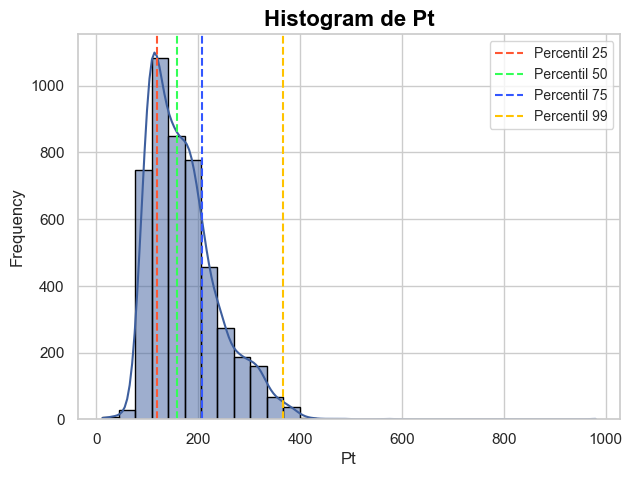

In [80]:
# Configuración del estilo general del gráfico
plt.figure(figsize=(7, 5))  # Tamaño de la figura
sns.set_theme(style="whitegrid")  # Tema limpio con fondo blanco

# Crear el histograma
sns.histplot(matches_length['Pt'], bins=30, kde=True, color="#3e5f9e", edgecolor="black")

# Percentiles
plt.axvline(percentiles['25%'], color='#FF5733', linestyle='--', label='Percentil 25')
plt.axvline(percentiles['50%'], color='#33FF57', linestyle='--', label='Percentil 50')
plt.axvline(percentiles['75%'], color='#3357FF', linestyle='--', label='Percentil 75')
plt.axvline(percentiles['99%'], color='#FFC300', linestyle='--', label='Percentil 99')

# Etiquetas y título
plt.title('Histogram de Pt', fontsize=16, weight='bold', color="black")
plt.xlabel('Pt', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Agregar leyenda
plt.legend(fontsize=10)

# Guardar gráfico
plt.savefig('viz_outputs/histograma_pt.png', facecolor='white', bbox_inches='tight')
# Mostrar gráfico
plt.show()

Como se puede observar, la mayoría de los partidos duran entre 100 y 200 puntos. Sin embargo, hay un buen porcentaje de partidos que duran más. De +-380 en adelante, excepcionales.

Lo mismo con la duración de los rallies.

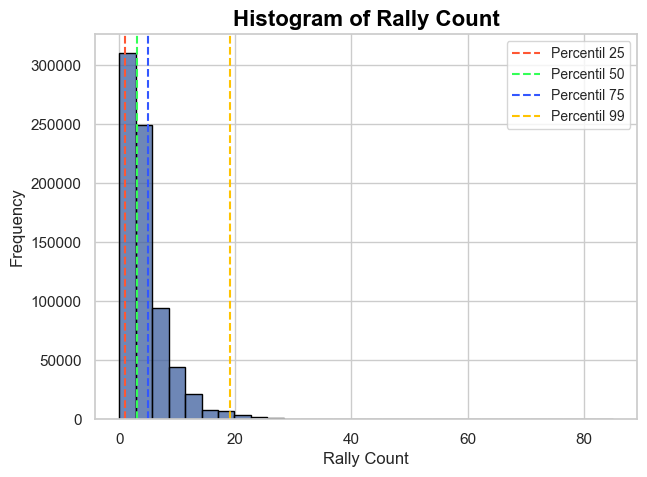

In [81]:
percentiles_rallies = df_main['rallyCount'].describe(percentiles=[.25, .5, .75, .95, .99])[['25%', '50%', '75%', '95%','99%']]

# Configuración del estilo general del gráfico
plt.figure(figsize=(7, 5))  # Tamaño de la figura
sns.set_theme(style="whitegrid")  # Tema limpio con fondo blanco

# Crear el histograma
sns.histplot(df_main['rallyCount'], bins=30, color="#3e5f9e", edgecolor="black")

# Percentiles
plt.axvline(percentiles_rallies['25%'], color='#FF5733', linestyle='--', label='Percentil 25')
plt.axvline(percentiles_rallies['50%'], color='#33FF57', linestyle='--', label='Percentil 50')
plt.axvline(percentiles_rallies['75%'], color='#3357FF', linestyle='--', label='Percentil 75')
plt.axvline(percentiles_rallies['99%'], color='#FFC300', linestyle='--', label='Percentil 99')

# Etiquetas y título
plt.title('Histogram of Rally Count', fontsize=16, weight='bold', color="black")
plt.xlabel('Rally Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Agregar leyenda
plt.legend(fontsize=10)

plt.savefig('viz_outputs/histograma_rally_count.png', facecolor='white', bbox_inches='tight')
# Mostrar gráfico
plt.show()

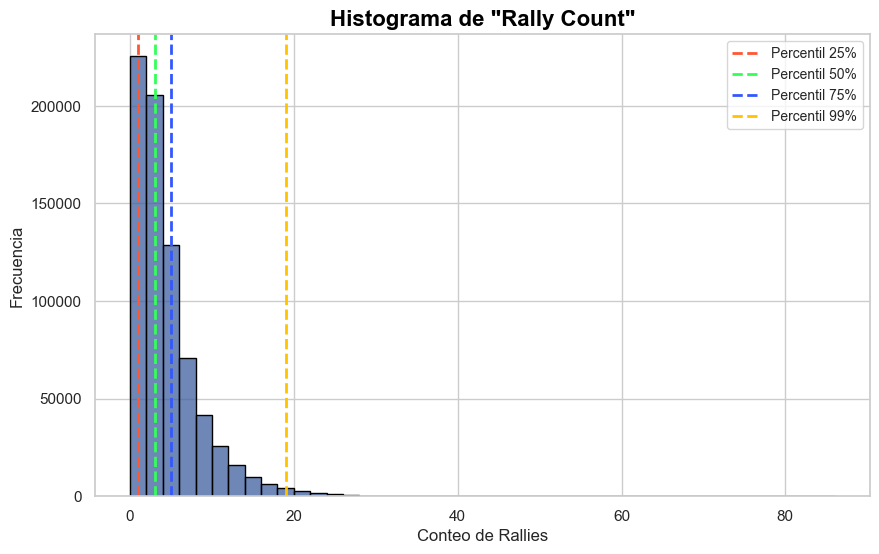

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supongamos que tienes el DataFrame df_main

# Calcular los percentiles del rallyCount
percentiles_rallies = df_main['rallyCount'].describe(percentiles=[.25, .5, .75, .95, .99])[['25%', '50%', '75%', '95%', '99%']]

# Configuración del estilo general del gráfico
plt.figure(figsize=(10, 6))  # Ajuste del tamaño de la figura
sns.set_theme(style="whitegrid")  # Tema limpio con fondo blanco

# Crear el histograma con un bin para cada dos valores únicos
rally_min, rally_max = df_main['rallyCount'].min(), df_main['rallyCount'].max()
bins = np.arange(rally_min, rally_max + 2, 2)  # Bins con intervalos de 2 unidades

sns.histplot(df_main['rallyCount'], bins=bins, color="#3e5f9e", edgecolor="black")

# Añadir las líneas de los percentiles al histograma
percentiles_colors = {
    '25%': '#FF5733',
    '50%': '#33FF57',
    '75%': '#3357FF',
    '99%': '#FFC300'
}

for perc, color in percentiles_colors.items():
    plt.axvline(percentiles_rallies[perc], color=color, linestyle='--', linewidth=2, label=f'Percentil {perc}')

# Etiquetas y título
plt.title('Histograma de "Rally Count"', fontsize=16, weight='bold', color="black")
plt.xlabel('Conteo de Rallies', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Agregar leyenda
plt.legend(fontsize=10)

# Guardar y mostrar gráfico
plt.savefig('viz_outputs/histograma_rally_count.png', facecolor='white', bbox_inches='tight')
plt.show()


In [83]:
print(round(df_main['rallyCount'].mean(),2))
percentiles_rallies

4.14


25%     1.0
50%     3.0
75%     5.0
95%    12.0
99%    19.0
Name: rallyCount, dtype: float64

Con un **promedio de 4.2** y la distribucion del grafico,  es claro que la mayoría de los puntos se definen en los primeros 10 golpes. Los partidos por su parte rara vez superan los 400 puntos jugados.
 El porcentaje de rallies y partidos que se extienden mucho más allá de la media no son errores sino eventos extremadamente raros, que rompen records de duración o rallies demasiado inusuales, que no son representativos de la mayoría de los partidos. Sin embargo, estos eventos no son ni relevantes ni representativos para el análisis general, por lo que se filtran:

In [84]:
#Filtrar (eliminar) partidos donde pt es mayor a 400
df_main = df_main[df_main['Pt'] <= 400]

#Filtrar (eliminar) partidos donde rallyCount es mayor a 50
df_main = df_main[df_main['rallyCount'] <= 50]

## Analisis por grand slam

El analisis de los 4 torneos de Grand Slam puede arrojar informacion interesante. Son los torneos mas importantes, distribuidos a lo largo del año y en diferentes superficies.

In [85]:
#Use only the first two elemtens of the str split
df_points_grand_slam[['year', 'tournament', 'id']] = df_points_grand_slam['match_id'].str.split('-', expand=True)

In [86]:
df_points_grand_slam['ElapsedTime'].value_counts().sort_values(ascending=True).head(30)

4:41:20     1
26:29:09    1
26:27:41    1
26:26:57    1
26:25:12    1
26:23:46    1
26:22:51    1
26:21:59    1
26:21:10    1
26:20:02    1
26:19:08    1
26:18:33    1
26:17:07    1
26:16:13    1
26:14:35    1
26:13:55    1
26:12:44    1
26:12:06    1
26:11:37    1
26:37:16    1
26:38:33    1
42:54:45    1
26:39:17    1
42:53:54    1
42:53:14    1
42:52:31    1
26:29:33    1
26:30:37    1
26:31:08    1
26:31:40    1
Name: ElapsedTime, dtype: int64

### Analisis de duración

In [87]:
#convertir la columna ElapsedTime (hh:mm:ss) a formato correcto
df_points_grand_slam['ElapsedTime'] = df_points_grand_slam['ElapsedTime'].astype(str)

def validate_time_format(val):
    # Patrón para validar formato correcto hh:mm:ss
    pattern = re.compile(r"^\d{1,2}:\d{1,2}:\d{1,2}$")
    if pattern.match(val):
        return val  # Si es válido, regresar el valor
    else:
        return '00:00:00'  # Reemplazar valores no válidos

# Aplicar validación a la columna
df_points_grand_slam['ElapsedTime'] = df_points_grand_slam['ElapsedTime'].apply(validate_time_format)


import traceback
try:
    df_points_grand_slam['ElapsedTime'] = pd.to_timedelta(df_points_grand_slam['ElapsedTime'], errors='coerce')
except Exception as e:
    print("Error:")
    traceback.print_exc()


In [88]:
#groupby max of each match and add tournament
match_dur_per_tournaent = df_points_grand_slam.groupby('match_id').agg({'ElapsedTime': 'max', 'tournament': 'first'}).reset_index()

#Filtro de menores a 1 hora (por walkover) y mayores a 6 horas (por inusuales)
match_dur_per_tournaent = match_dur_per_tournaent[(match_dur_per_tournaent['ElapsedTime'] > '01:00:00') & (match_dur_per_tournaent['ElapsedTime'] < '06:00:00')].groupby('tournament')['ElapsedTime'].describe()[['mean','25%', '50%', '75%']]

match_dur_per_tournaent[['mean','25%', '50%', '75%']] = match_dur_per_tournaent[['mean','25%', '50%', '75%']].apply(lambda x: pd.to_timedelta(x))

for col in ['mean','25%', '50%', '75%']:
    match_dur_per_tournaent[col] = match_dur_per_tournaent[col].dt.total_seconds() / 60

In [89]:
match_dur_per_tournaent

,mean,25%,50%,75%
tournament,,,,
ausopen,150.733935,114.066667,142.983333,180.066667
frenchopen,152.789306,115.608333,141.875000,181.712500
usopen,158.531991,121.191667,153.750000,191.958333
wimbledon,152.315295,113.870833,144.550000,182.104167


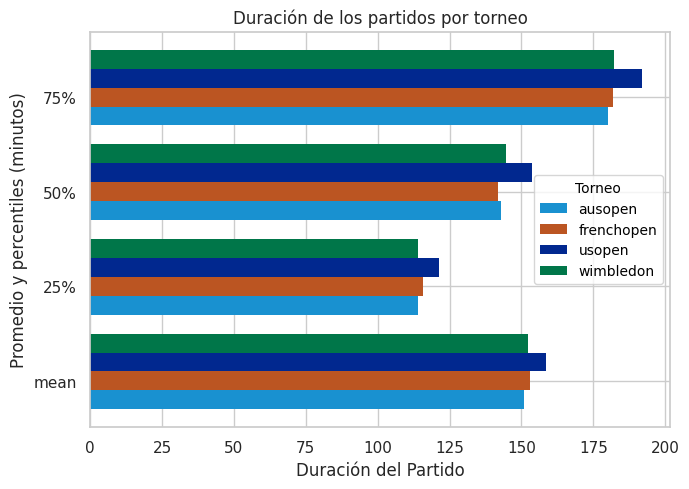

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
tournaments = match_dur_per_tournaent.index
metrics = match_dur_per_tournaent.columns

color_azulado_elegido = "#175c99"

# Definir colores personalizados para cada torneo
tournament_colors = {
    'ausopen': '#1991d0',
    'frenchopen': '#bb5522',
    'usopen': '#01288f',
    'wimbledon': '#007649'
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(7, 5))
plt.style.use('default')  # Fondo blanco

# Espaciado para separar las barras por torneo
bar_width = 0.2
index = np.arange(len(metrics))

# Graficar cada torneo con diferentes colores y ubicaciones
for idx, tournament in enumerate(tournaments):
    ax.barh(index + idx * bar_width, match_dur_per_tournaent.loc[tournament], height=bar_width,
            label=tournament, color=tournament_colors.get(tournament))

# Añadir etiquetas y título
plt.xlabel('Duración del Partido')
plt.ylabel('Promedio y percentiles (minutos)')
plt.title('Duración de los partidos por torneo')
plt.yticks(index + bar_width, metrics)
plt.legend(title='Torneo')

# Mostrar el gráfico
plt.tight_layout()
plt.savefig('viz_outputs/duracion_por_slam.png', facecolor='white', bbox_inches='tight')

plt.show()

Contrario a lo que se podría pensar, los partidos tienen una duracion similar en los 4 torneos de Grand Slam. US Open destaca levemente en duración, pero no es significativo.

## Análisis de saque

Particularmente interesa la probabilidad de hacer un Ace.

In [91]:
df_speed_kmh = df_points_grand_slam[df_points_grand_slam['Speed_KMH'] != 0]

In [92]:
df_speed_kmh.groupby('tournament')['Speed_KMH'].describe()

,count,mean,std,min,25%,50%,75%,max
tournament,,,,,,,,
ausopen,123476.0,170.998696,23.408805,83.0,152.0,173.0,190.0,242.0
frenchopen,126367.0,169.855128,23.386659,98.0,151.0,172.0,189.0,237.0
usopen,246956.0,169.399845,23.622198,96.0,151.0,170.0,188.0,247.0
wimbledon,181164.0,176.327769,21.014070,96.0,160.0,178.0,193.0,236.0


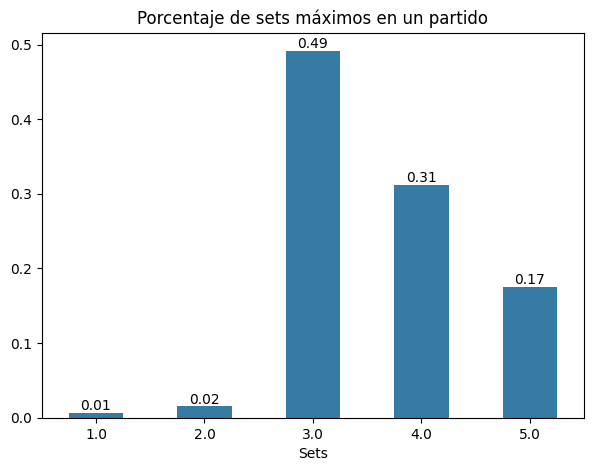

In [93]:
sets_maximos_en_partido = df_points_grand_slam.groupby('match_id')['SetNo'].max().value_counts(normalize=True).sort_index()

plt.figure(figsize=(7, 5))
sets_maximos_en_partido.plot(kind='bar', color='#367ba3')
plt.title('Porcentaje de sets máximos en un partido')
plt.xlabel('Sets')
plt.xticks(rotation=0)
for i, v in enumerate(sets_maximos_en_partido):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.savefig('viz_outputs/sets_maximos.png', facecolor='white', bbox_inches='tight')
plt.show()

El 50% por ciento de los partidos se juegan a 3 sets. Solo un 17% llegan a los 5 sets. Solo un 3% terminan antes (WO).

#### Relación entre velocidad del saque y probabilidad de Ace

El mejor modo de analizar el impacto de la velocidad del saque en la probabilidad de hacer un Ace es mediante un modelo simple, de clasificacion (Ace o NO Ace). Si bien a la hora de modelar se tienen en cuenta muchas variables, la velocidad del saque la que interesa en este caso.

Se siguen todos los pasos tipicos de procesamiento de datos para un modelo de machine learning simple:
* Creacion de variable target y re balanceo de la misma
* Encoding de variables categoricas
* Estandarizacion de variables numericas
* Modelo de regresion logistica

In [94]:
#Crear columna 'Ace_y', si Serve indicator es 1, usar valor de P1Ace, si es == 2, usar valor de P2Ace, si no, filtrar afuera
df_speed_kmh['Ace_y'] = np.where(df_speed_kmh['ServeIndicator'] == 1, df_speed_kmh['P1Ace'], np.where(df_speed_kmh['ServeIndicator'] == 2, df_speed_kmh['P2Ace'], np.nan))

C:\Users\agusd\AppData\Local\Temp\ipykernel_22576\1616167373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speed_kmh['Ace_y'] = np.where(df_speed_kmh['ServeIndicator'] == 1, df_speed_kmh['P1Ace'], np.where(df_speed_kmh['ServeIndicator'] == 2, df_speed_kmh['P2Ace'], np.nan))


In [95]:
predictors = ['Speed_KMH', 'ServeWidth','ServeDepth', 'ServeNumber']

#drop na values
speed_kmh_model = df_speed_kmh[predictors + ['Ace_y']].dropna().reset_index(drop=True)

In [96]:
# encoding de Width y Depth
categorical_columns = ['ServeWidth', 'ServeDepth']
speed_kmh_model = pd.get_dummies(speed_kmh_model, columns=categorical_columns, drop_first=True)

In [97]:
# standardize 
from sklearn.preprocessing import StandardScaler

# Guardar media y std de Speed_KMH
speed_kmh_mean = speed_kmh_model['Speed_KMH'].mean()
speed_kmh_std = speed_kmh_model['Speed_KMH'].std()

scaler = StandardScaler()
speed_kmh_model['Speed_KMH'] = scaler.fit_transform(speed_kmh_model[['Speed_KMH']])

speed_kmh_model.head(3)

,Speed_KMH,ServeNumber,Ace_y,ServeWidth_BC,ServeWidth_BW,ServeWidth_C,ServeWidth_W,ServeDepth_NCTL
0,-1.562397,2.0,0.0,0,1,0,0,1
1,0.771630,1.0,0.0,0,0,1,0,1
2,-0.901823,2.0,0.0,0,1,0,0,1


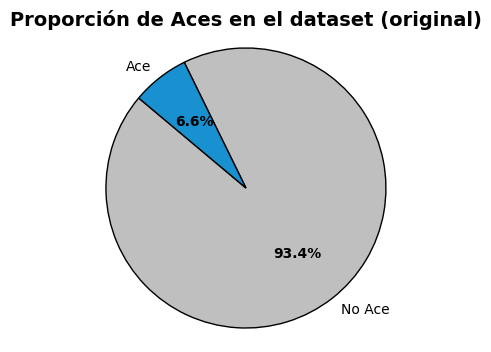

In [98]:
# Calcular proporciones
q_aces = speed_kmh_model['Ace_y'].value_counts(normalize=True)

# Colores personalizados
colors = ['#bfbfbf', tournament_colors['ausopen']]  # Gris más claro y azul

# Crear el gráfico de pastel
plt.figure(figsize=(6, 4))
wedges, texts, autotexts = plt.pie(
    q_aces,
    labels=['No Ace', 'Ace'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={'fontsize': 10},
    wedgeprops={'edgecolor': 'black'}
)

# Aplicar estilo a los porcentajes
for autotext in autotexts:
    autotext.set_fontweight('bold')  # Valores en negrita
    autotext.set_color('black')  # Colores de los textos

# Título
plt.title('Proporción de Aces en el dataset (original)', fontsize=14, weight='bold', color='black')

# Asegurar proporción circular
plt.axis('equal')

# Guardar y mostrar
plt.savefig('viz_outputs/proporcion_aces_original.png', facecolor='white', bbox_inches='tight')
plt.show()


In [99]:
from sklearn.utils import resample

# Rebalancear todo el dataset
class_0 = speed_kmh_model[speed_kmh_model['Ace_y'] == 0]
class_1 = speed_kmh_model[speed_kmh_model['Ace_y'] == 1]

# Ajustar tamaños directamente
class_1_resampled = resample(class_1, n_samples=int(len(speed_kmh_model) * 0.40), replace=True, random_state=42)
class_0_resampled = resample(class_0, n_samples=int(len(speed_kmh_model) * 0.60), replace=False, random_state=42)

# Combinar y mezclar
speed_kmh_model = pd.concat([class_1_resampled, class_0_resampled]).sample(frac=1, random_state=42)


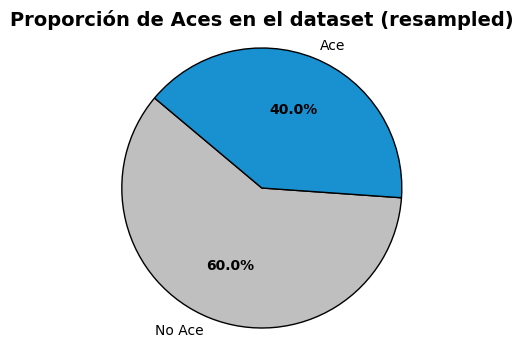

In [100]:
# Calcular proporciones
q_aces = speed_kmh_model['Ace_y'].value_counts(normalize=True)

# Colores personalizados
colors = ['#bfbfbf', tournament_colors['ausopen']]  # Gris más claro y azul

# Crear el gráfico de pastel
plt.figure(figsize=(6, 4))
wedges, texts, autotexts = plt.pie(
    q_aces,
    labels=['No Ace', 'Ace'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={'fontsize': 10},
    wedgeprops={'edgecolor': 'black'}
)

# Aplicar estilo a los porcentajes
for autotext in autotexts:
    autotext.set_fontweight('bold')  # Valores en negrita
    autotext.set_color('black')  # Colores de los textos

# Título
plt.title('Proporción de Aces en el dataset (resampled)', fontsize=14, weight='bold', color='black')

# Asegurar proporción circular
plt.axis('equal')

# Guardar y mostrar
plt.savefig('viz_outputs/proporcion_aces_resample.png', facecolor='white', bbox_inches='tight')
plt.show()


In [101]:
X = speed_kmh_model.drop('Ace_y', axis=1)
y = speed_kmh_model['Ace_y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predicción y evaluación
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))


ROC-AUC: 0.8520902478249285
Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.85      0.74      0.79     33646
         1.0       0.68      0.81      0.74     23014

    accuracy                           0.77     56660
   macro avg       0.77      0.78      0.77     56660
weighted avg       0.78      0.77      0.77     56660


In [103]:
# Obtener el coeficiente del modelo
coeficientes = log_reg.coef_[0]  # log_reg.coef_ devuelve un array bidimensional, por lo que accedemos al primer elemento
nombre_caracteristicas = ["potencia", "otra_caracteristica1", "otra_caracteristica2"]  # Lista con los nombres de las características
coeficientes_dict = dict(zip(nombre_caracteristicas, coeficientes))

# Obtener el coeficiente correspondiente a la potencia del saque
coef_potencia = coeficientes_dict["potencia"]

# Mostrar el coeficiente
print(f"El coeficiente de la potencia del saque es: {coef_potencia:.4f}")

# Interpretación
print(f"Por cada aumento de una unidad en la potencia del saque, el log-odds de la probabilidad de un Ace cambia en {coef_potencia:.4f}")

cambio_odds = np.exp(coef_potencia)
print(f"Un aumento de una unidad en la potencia del saque multiplica los odds de un Ace por {cambio_odds:.4f}")

El coeficiente de la potencia del saque es: 0.9025
Por cada aumento de una unidad en la potencia del saque, el log-odds de la probabilidad de un Ace cambia en 0.9025
Un aumento de una unidad en la potencia del saque multiplica los odds de un Ace por 2.4658


Buen Modelo, con un ROC-AUC de 0.86. Producto del balanceo tiene una buena media entre precision y recall para predecir los Ace efectivamente.

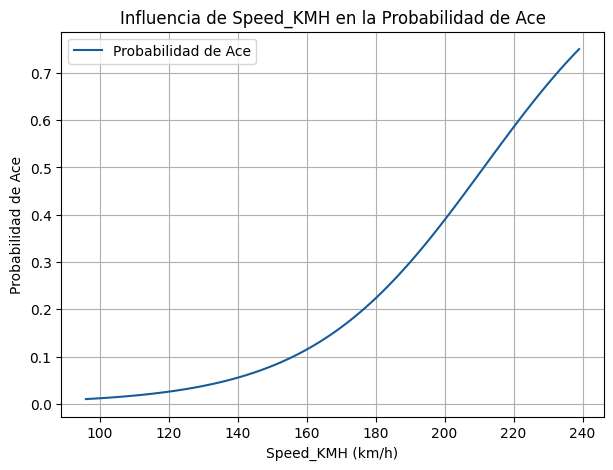

In [104]:
# Generar valores estandarizados para Speed_KMH
standardized_speed_kmh = np.linspace(X_train['Speed_KMH'].min(), X_train['Speed_KMH'].max(), 100)

# Desestandarizar los valores
original_speed_kmh = standardized_speed_kmh * speed_kmh_std + speed_kmh_mean

# Mantener otras variables constantes
average_values = X_train.mean().to_frame().T
average_values = average_values.loc[average_values.index.repeat(100)].reset_index(drop=True)
average_values['Speed_KMH'] = standardized_speed_kmh

# Predecir probabilidades
probabilities = log_reg.predict_proba(average_values)[:, 1]

# Graficar con valores originales
plt.figure(figsize=(7, 5))
plt.plot(original_speed_kmh, probabilities, label='Probabilidad de Ace', color = '#175c99')
plt.xlabel('Speed_KMH (km/h)')
plt.ylabel('Probabilidad de Ace')
plt.title('Influencia de Speed_KMH en la Probabilidad de Ace')
plt.legend()
plt.grid()

plt.savefig('viz_outputs/influencia_speed_kmh.png', facecolor='white', bbox_inches='tight')
plt.show()

**La siguiente visualizacion tiene propositos expositorios, no es parte del analisis**

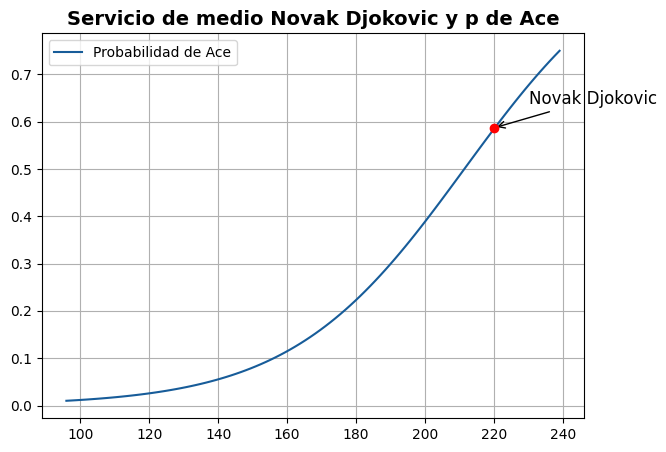

In [105]:
# Generar valores estandarizados para Speed_KMH
standardized_speed_kmh = np.linspace(X_train['Speed_KMH'].min(), X_train['Speed_KMH'].max(), 100)

# Desestandarizar los valores
original_speed_kmh = standardized_speed_kmh * speed_kmh_std + speed_kmh_mean

jugador_elegido = 'Novak Djokovic'

# Mantener otras variables constantes
average_values = X_train.mean().to_frame().T
average_values = average_values.loc[average_values.index.repeat(100)].reset_index(drop=True)
average_values['Speed_KMH'] = standardized_speed_kmh

# Predecir probabilidades
probabilities = log_reg.predict_proba(average_values)[:, 1]

# Velocidad específica y su respectiva probabilidad
specific_speed_kmh = 220  # Velocidad deseada
specific_speed_std = (specific_speed_kmh - speed_kmh_mean) / speed_kmh_std

# Encontrar el índice más cercano en la matriz estándar
closest_index = (np.abs(average_values['Speed_KMH'] - specific_speed_std)).idxmin()
specific_probability = log_reg.predict_proba(average_values.iloc[[closest_index]])[0, 1]

# Graficar con valores originales
plt.figure(figsize=(7, 5))
plt.plot(original_speed_kmh, probabilities, label='Probabilidad de Ace', color='#175c99')
#plt.xlabel('Speed_KMH (km/h)', fontsize=12)
#plt.ylabel('Probabilidad de Ace', fontsize=12)
plt.title(f'Servicio de medio {jugador_elegido} y p de Ace', fontsize=14, weight='bold')
plt.legend(fontsize=10)
plt.grid()

# Añadir el punto específico
plt.scatter(specific_speed_kmh, specific_probability, color='red', zorder=5, label='Punto específico')
plt.annotate(
    jugador_elegido,  # Texto de la anotación
    xy=(specific_speed_kmh, specific_probability),  # Posición del punto
    xytext=(specific_speed_kmh + 10, specific_probability + 0.05),  # Posición del texto
    fontsize=12,
    color='black',
    arrowprops=dict(facecolor='black', arrowstyle='->')  # Flecha
)

# Guardar y mostrar
plt.savefig('viz_outputs/influencia_speed_kmh_djokovic.png', facecolor='white', bbox_inches='tight')
plt.show()

##### Analisis de servicio por direccion
La direccion del saque tambien es un factor importante en el tenis, por lo que merece un simple analisis.

In [106]:
analisis_dep_wid_saque = df_points_grand_slam.dropna(subset=['ServeWidth', 'ServeDepth'])
gr_saques = analisis_dep_wid_saque.groupby('ServeWidth').agg({'Speed_KMH': 'mean', 'ServeWidth': 'count','P1Ace': 'sum'})

In [107]:
saques_dict = {
    'B': 'Body',
    'BC': 'Body/Center',
    'BW': 'Body/Wide',
    'C': 'Center',
    'W': 'Wide'
}

gr_saques['P1_ace_pct'] = round((gr_saques['P1Ace'] / gr_saques['P1Ace'].sum()) * 100, 2)
gr_saques['Ace_pct_from_dir_type'] = round(gr_saques['P1Ace'] / gr_saques['ServeWidth'] * 100, 2)
gr_saques = gr_saques.sort_values(by='Ace_pct_from_dir_type', ascending=False).reset_index(names='golpe')
gr_saques['golpe'] = gr_saques['golpe'].replace(saques_dict)
gr_saques

,golpe,Speed_KMH,ServeWidth,P1Ace,P1_ace_pct,Ace_pct_from_dir_type
0,Center,152.751505,100199,8619.0,55.99,8.60
1,Wide,141.460661,84305,6482.0,42.10,7.69
2,Body/Wide,135.326101,65673,170.0,1.10,0.26
3,Body/Center,137.268744,59778,107.0,0.70,0.18
4,Body,126.922447,35756,17.0,0.11,0.05


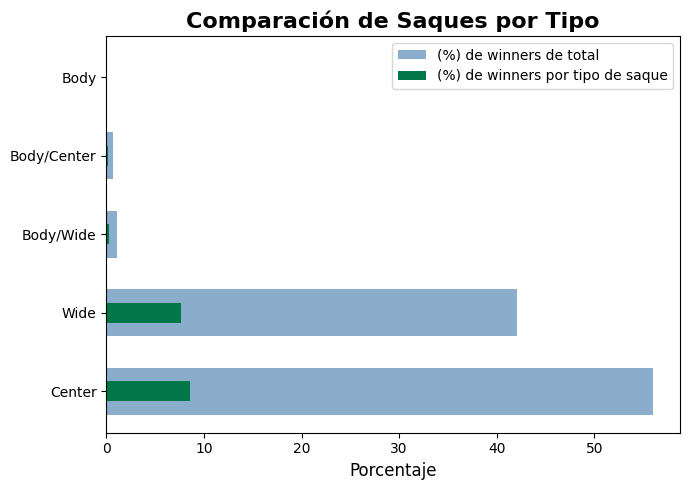

In [108]:
# Ordenar el dataset según una de las métricas
gr_saques_sorted = gr_saques.sort_values(by='Ace_pct_from_dir_type', ascending=False)

# Datos del DataFrame ordenado
serves = gr_saques_sorted['golpe']  # Asegúrate de que exista una columna con los tipos de saque
serve_width_pct = gr_saques_sorted['P1_ace_pct']
ace_pct = gr_saques_sorted['Ace_pct_from_dir_type']#P1_ace_pct

# Posiciones en el eje y
y = np.arange(len(serves))

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(7, 5))

# Ancho de las barras
bar_width = 0.6
narrow_bar_width = 0.25

# Graficar la primera métrica (barra más ancha con transparencia)
bars1 = ax.barh(y, serve_width_pct, height=bar_width, color='#175c99', alpha=0.5, label='(%) de winners de total')

# Graficar la segunda métrica (barra más estrecha sin transparencia, encima)
bars2 = ax.barh(y, ace_pct, height=narrow_bar_width, color=tournament_colors['wimbledon'], label='(%) de winners por tipo de saque')

# Etiquetas y título
ax.set_xlabel('Porcentaje', fontsize=12)
ax.set_yticks(y)
ax.set_yticklabels(serves, fontsize=10)
plt.title('Comparación de Saques por Tipo', fontsize=16, weight='bold', color='black')

# Añadir leyenda
plt.legend(fontsize=10)

# Ajustar el diseño y guardar el gráfico
plt.tight_layout()
plt.savefig('viz_outputs/comparacion_saques_sorted.png', facecolor='white', bbox_inches='tight')

# Mostrar el gráfico
plt.show()


Los saques 'Center' y 'Wide' son los que mas Aces generan, tanto del total como relativos a la cantidad de saques de ese tipo. Los saques 'Body' y 'Body/Wide' son los menos efectivos y mas lentos. Uno puede inferir que los jugadores sacan al cuerpo del rival (centrado y despacio) para evitar errores.

# Analisis por golpes

In [109]:
df_golpes_no_retornos = df_full_sequence[df_full_sequence['rallyCount'] > 1]

analisis_winners = df_golpes_no_retornos[(df_golpes_no_retornos['rally_sequence'].str[-1] == '*') & (df_golpes_no_retornos['rallyCount'] > 2)]
analisis_winners_retornos = df_golpes_no_retornos[(df_golpes_no_retornos['rallyCount'] == 2) & (df_golpes_no_retornos['rally_sequence'].str[-1] == '*')]

analisis_f_errors = df_golpes_no_retornos[df_golpes_no_retornos['rally_sequence'].str[-1] == '#']
analisis_u_errors = df_golpes_no_retornos[df_golpes_no_retornos['rally_sequence'].str[-1] == '@']
analisis_return_errors = df_full_sequence[df_full_sequence['rallyCount'] == 1]

In [110]:
analisis_winners[['golpe', 'direccion']] = analisis_winners['rally_sequence'].str.split(' ').str[-1].apply(lambda x: pd.Series(list(x)))[[0,1]]
analisis_winners.head(3)

C:\Users\agusd\AppData\Local\Temp\ipykernel_22576\2099941453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analisis_winners[['golpe', 'direccion']] = analisis_winners['rally_sequence'].str.split(' ').str[-1].apply(lambda x: pd.Series(list(x)))[[0,1]]
C:\Users\agusd\AppData\Local\Temp\ipykernel_22576\2099941453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analisis_winners[['golpe', 'direccion']] = analisis_winners['rally_sequence'].str.split(' ').str[-1].apply(lambda x: pd.Series(list(x)))[[0,1]

,1stIn,2ndIn,rally_sequence,Pt,Set1,Set2,Gm1,Gm2,TbSet,TB?,...,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,golpe,direccion
1,0,1.0,6 b19 f1 b2 s1 f3 f2 j2*,2,0,0,0.0,0.0,1,0,...,False,True,False,False,False,2,0,8,j,2
2,0,1.0,4 b28 f2 o1*,3,0,0,0.0,0.0,1,0,...,False,True,False,False,False,2,0,4,o,1
3,1,NaN,6 s28 f3*,4,0,0,0.0,0.0,1,0,...,False,True,False,False,False,1,1,3,f,3


In [111]:
# Analizado como si fuese a rival diestro
direccion_dict = {'1': 'derecha', '2': 'medio', '3': 'izquierda'}

direction_count = analisis_winners[analisis_winners['direccion'].isin(['1','3','2'])]['direccion'].value_counts(normalize=True).reset_index()
direction_count['index'] = direction_count['index'].replace(direccion_dict)
direction_count

,index,direccion
0,derecha,0.515793
1,izquierda,0.430749
2,medio,0.053458


In [112]:
golpes_dict = {
    'f': 'golpe de derecha',
    'b': 'golpe de revés',
    'r': 'slice de derecha',
    's': 'slice de revés',
    'v': 'volea de derecha',
    'z': 'volea de revés',
    'o': 'smash',
    'p': 'smash "de revés"',
    'u': 'drop shot de derecha',
    'y': 'drop shot de revés',
    'l': 'globo de derecha',
    'm': 'globo de revés',
    'h': 'media volea de derecha',
    'i': 'media volea de revés',
    'j': 'volea con swing de derecha',
    'k': 'volea con swing de revés',
    't': 'trickshots',
    'q': 'golpe desconocido',
    'n': 'error'
}


winners_count = analisis_winners['golpe'].value_counts().reset_index()
winners_count['index'] = winners_count['index'].replace(golpes_dict)

In [113]:
def contar_golpes(sequence, golpes_dict):
    # Crear un diccionario para almacenar las cuentas
    counts = {golpe: 0 for golpe in golpes_dict.keys()}
    # Recorrer cada carácter en la secuencia y contar
    for char in sequence.split():
        if char[0] in counts:
            counts[char[0]] += 1
    return counts

"""#Aplicar la función a cada fila y almacenar los resultados en un nuevo DataFrame
conteos_df = df_full_sequence['rally_sequence'].apply(lambda x: contar_golpes(x, golpes_dict)).apply(pd.Series)

# Unir los conteos al DataFrame original
df_conteo_final = pd.concat([df_full_sequence, conteos_df], axis=1)

df_conteo_final.to_csv('data_output/df_conteo_golpes.csv', index=False)"""

"#Aplicar la función a cada fila y almacenar los resultados en un nuevo DataFrame\nconteos_df = df_full_sequence['rally_sequence'].apply(lambda x: contar_golpes(x, golpes_dict)).apply(pd.Series)\n\n# Unir los conteos al DataFrame original\ndf_conteo_final = pd.concat([df_full_sequence, conteos_df], axis=1)\n\ndf_conteo_final.to_csv('data_output/df_conteo_golpes.csv', index=False)"

![](viz_outputs/conteo_golpes.png)

In [114]:
df_conteo_final = pd.read_csv('data_output/df_conteo_golpes.csv', low_memory=False)

In [115]:
totales_por_golpe = pd.DataFrame(df_conteo_final[golpes_dict.keys()].sum()).reset_index()
#remove last row
totales_por_golpe = totales_por_golpe[:-2]

totales_por_golpe['index'] = totales_por_golpe['index'].replace(golpes_dict)
totales_golpes_analisis = totales_por_golpe.merge(winners_count, left_on='index', right_on='index')
totales_golpes_analisis.columns = ['Golpe', 'Total', 'Winners']

totales_golpes_analisis['pct_entre_winners'] = totales_golpes_analisis['Winners'] / totales_golpes_analisis['Winners'].sum()

totales_golpes_analisis['pct_entre_golpe'] = totales_golpes_analisis['Winners'] / totales_golpes_analisis['Total']

totales_golpes_analisis[['pct_entre_winners', 'pct_entre_golpe']] = totales_golpes_analisis[['pct_entre_winners', 'pct_entre_golpe']].apply(lambda x: round(x * 100,2))

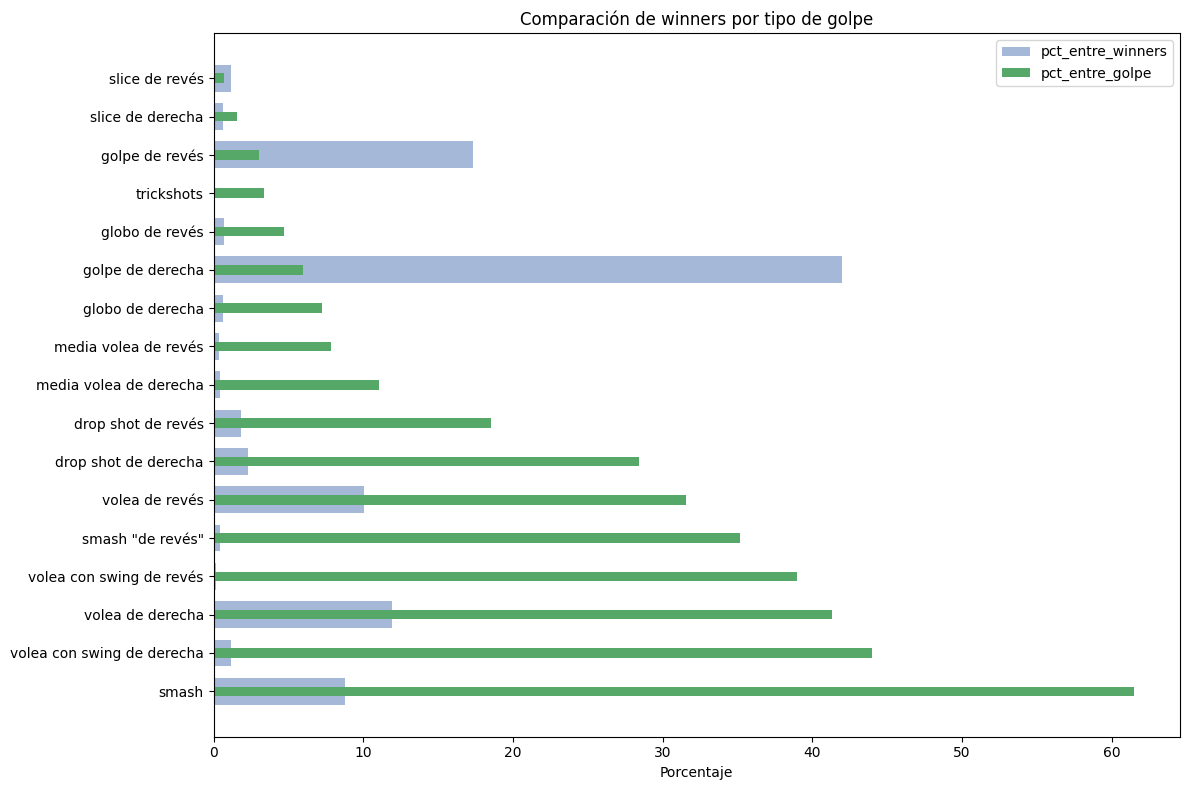

In [116]:
totales_golpes_analisis_sorted = totales_golpes_analisis.sort_values(by='pct_entre_golpe', ascending=False)

# Datos del DataFrame ordenado
golpes = totales_golpes_analisis_sorted['Golpe']
winner_pct_of_winners = totales_golpes_analisis_sorted['pct_entre_winners']
winners_pct_of_total = totales_golpes_analisis_sorted['pct_entre_golpe']

# Posiciones en el eje y
y = np.arange(len(golpes))

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Ancho de las barras
bar_width = 0.7
narrow_bar_width = 0.25

# Graficar la primera métrica (barra más ancha con transparencia)
bars1 = ax.barh(y, winner_pct_of_winners, height=bar_width, color='b', alpha=0.5, label='pct_entre_winners')

# Graficar la segunda métrica (barra más estrecha sin transparencia, encima)
bars2 = ax.barh(y, winners_pct_of_total, height=narrow_bar_width, color='g', label='pct_entre_golpe')

# Etiquetas y título
ax.set_xlabel('Porcentaje')
ax.set_yticks(y)
ax.set_yticklabels(golpes)
plt.title('Comparación de winners por tipo de golpe')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()

plt.savefig('viz_outputs/comparacion_winners_golpes_sorted.png', facecolor='white', bbox_inches='tight')
plt.show()

De esta manera analizamos desde dos perspectivas:
* Porcentaje de golpes ganadores respecto al total de los winners (azul). Logicamente la derecha y el revés son los golpes más efectivos en este sentido.
* Porcentaje de golpes ganadores respecto al total de golpes de ese tipo (verde). En este caso, el smash y las voleas son los golpes más efectivos.

In [117]:
#normalizar "Total"
totales_golpes_analisis['Total_normalizado'] = round(totales_golpes_analisis['Total'] / totales_golpes_analisis['Total'].sum() * 100, 2)

#si golpe, no es golpe de derecha, golpe de revés o slice de derecha, sumar a otros
totales_golpes_analisis['Golpe_viz_pie'] = np.where(totales_golpes_analisis['Golpe'].isin(['golpe de derecha', 'golpe de revés', 'slice de revés']), totales_golpes_analisis['Golpe'], 'otros')

pie_golpes_prop = totales_golpes_analisis.groupby('Golpe_viz_pie').agg({'Total_normalizado': 'sum', 'Winners': 'sum'}).reset_index()

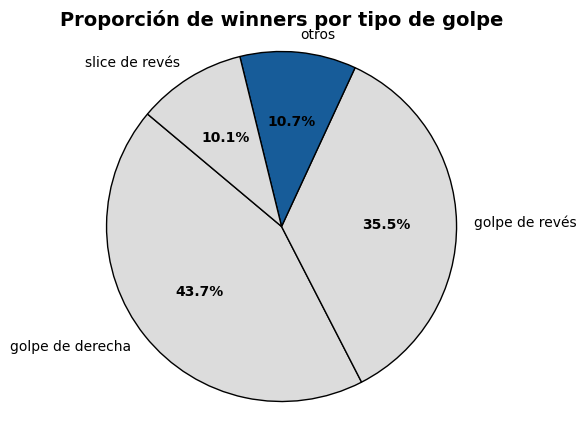

In [118]:
# Definir colores personalizados para el gráfico
colors = ['#dcdcdc' if label != 'otros' else color_azulado_elegido for label in pie_golpes_prop['Golpe_viz_pie']]

# Crear el gráfico de pastel con bordes y colores personalizados
plt.figure(figsize=(7, 5))
wedges, texts, autotexts = plt.pie(
    pie_golpes_prop['Total_normalizado'],
    labels=pie_golpes_prop['Golpe_viz_pie'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}  # Agregar bordes negros a las secciones
)

# Estilo para los porcentajes
for autotext in autotexts:
    autotext.set_fontweight('bold')  # Porcentajes en negrita
    autotext.set_color('black')  # Color negro para los textos

# Título
plt.title('Proporción de winners por tipo de golpe', fontsize=14, weight='bold', color='black')

# Asegurar proporción circular
plt.axis('equal')

# Guardar el gráfico
plt.savefig('viz_outputs/pie_golpes_prop.png', facecolor='white', bbox_inches='tight')

# Mostrar el gráfico
plt.show()


In [119]:
print(f"Cantidad de winners sobre golpes totales: {round(totales_golpes_analisis['Winners'].sum() / totales_golpes_analisis['Total'].sum() * 100,2)}")

Cantidad de winners sobre golpes totales: 6.2


# Visualizaciones para Demo

In [131]:
"""df_federer = pd.read_csv('data_output/df_exploded_full.csv')
df_federer = df_federer[df_federer['Player'] == 'Roger Federer']

conteos_df_federer = df_federer['Sequence'].apply(lambda x: contar_golpes(x, golpes_dict)).apply(pd.Series)

df_federer = pd.concat([df_federer, conteos_df_federer], axis=1)

df_federer.to_csv('data_output/df_federer_conteo_golpes.csv', index=False)"""

In [132]:
df_federer = pd.read_csv('data_output/df_federer_conteo_golpes.csv')

In [153]:
def count_numbers(column):
    counts = {'1': 0, '2': 0, '3': 0}
    for entry in column:
        counts['1'] += len(re.findall(r'1', entry))
        counts['2'] += len(re.findall(r'2', entry))
        counts['3'] += len(re.findall(r'3', entry))
    return counts

# Apply function to the column
counts = count_numbers(df_federer['Sequence'])
counts

{'1': 48163, '2': 54740, '3': 67238}

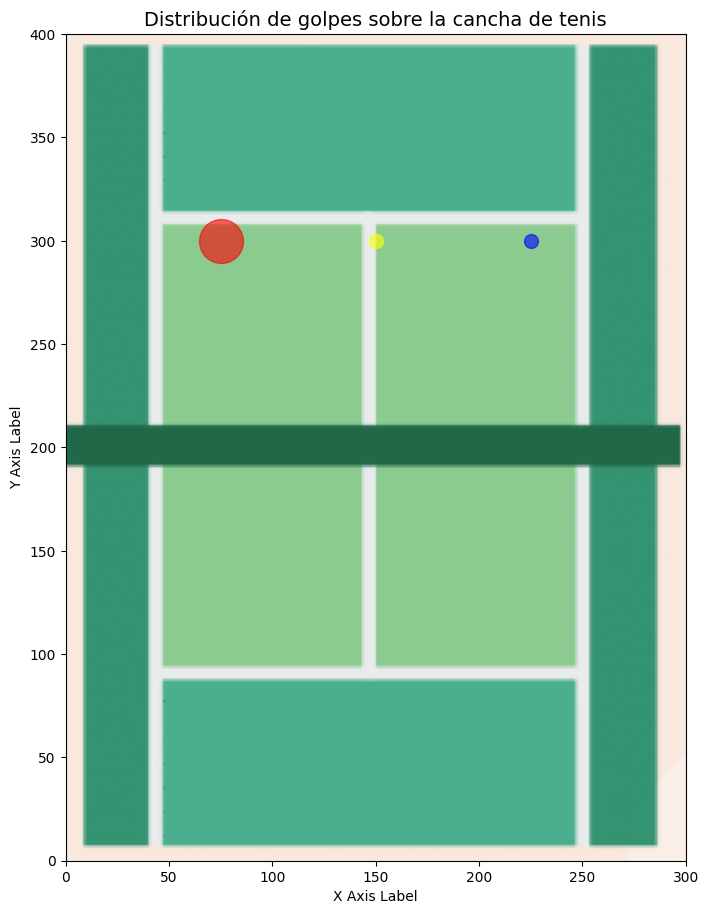

In [151]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the image
court_image = plt.imread('viz_outputs/court_image.png')

# Show image and make annotations on it
fig, ax = plt.subplots(figsize=(8, 12))

# Mostrar la imagen como fondo
ax.imshow(court_image, extent=[0, 300, 0, 400])

areas_coordinates = {
    "derecha": (75, 300),
    "centro": (150, 300),
    "izquierda": (150, 300)
}

# Convert dict_keys to a list
golpes_keys = list(golpes_dict.keys())

# Superponer los datos de golpes como puntos sobre la cancha
"""for i, (area, coord) in enumerate(areas_coordinates.items()):
    golpe_count = df_federer[golpes_keys[i]].sum()
    ax.scatter(*coord, s=golpe_count, color=["red", "yellow", "blue"][i], alpha=0.6, label=f"{area.capitalize()} ({golpe_count} golpes)")"""

# add single dots in coordinates, make them bigger with multiplier
ax.scatter(75, 300, s=100*10, color='red', alpha=0.6, label=f"Derecha")
ax.scatter(150, 300, s=100, color='yellow', alpha=0.6, label=f"Centro")
ax.scatter(225, 300, s=100, color='blue', alpha=0.6, label=f"Izquierda")

# Configuración de la gráfica
ax.set_xlim(0, 300)
ax.set_ylim(0, 400)
ax.set_xlabel('X Axis Label')  # Add x-axis label
ax.set_ylabel('Y Axis Label')  # Add y-axis label
#ax.legend(loc="upper right", fontsize=10)

# Mostrar la gráfica
plt.title("Distribución de golpes sobre la cancha de tenis", fontsize=14)
plt.show()